In [1]:
%pwd

'/Users/michelle/Downloads/DS-Unit-4-Sprint-1-NLP'

In [2]:
import pandas as pd

url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [3]:
# Much cleaner
shops['review_text_lc'] = shops['full_review_text'].apply(lambda x: x.lower())

In [4]:
shops['lc_split'] = shops['review_text_lc'].str.split(" ")
shops['lc_split'].head(5)

0    [, 11/25/2016, 1, check-in, love, love, loved,...
1    [, 12/2/2016, listed, in, date, night:, austin...
2    [, 11/30/2016, 1, check-in, listed, in, brunch...
3    [, 11/25/2016, very, cool, decor!, good, drink...
4    [, 12/3/2016, 1, check-in, they, are, located,...
Name: lc_split, dtype: object

In [5]:
"""
Import Statements
"""

# Base
from collections import Counter
import re
 
import pandas as pd

# Plotting
import squarify
import matplotlib.pyplot as plt
import seaborn as sns

# NLP Libraries

import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer

nlp = spacy.load("en_core_web_lg")

In [6]:
def tokenize(text):
    """Parses a string into a list of semantic units (words)

    Args:
        text (str): The string that the function will tokenize.

    Returns:
        list: tokens parsed out by the mechanics of your choice
    """
    
    tokens = re.sub(r'[^a-zA-Z ^0-9]', '', text)
    tokens = tokens.lower().split()
    
    return tokens

In [7]:
shops['tokens'] = shops['full_review_text'].apply(tokenize)

In [8]:
shops['tokens'].head(5)

0    [11252016, 1, checkin, love, love, loved, the,...
1    [1222016, listed, in, date, night, austin, amb...
2    [11302016, 1, checkin, listed, in, brunch, spo...
3    [11252016, very, cool, decor, good, drinks, ni...
4    [1232016, 1, checkin, they, are, located, with...
Name: tokens, dtype: object

In [9]:
# The object `Counter` takes an iterable, but you can instaniate an empty one and update it. 
word_counts = Counter()

# Update it based on a split of each of our documents
shops['tokens'].apply(lambda x: word_counts.update(x))

# Print out the 10 most common words
word_counts.most_common(10)

[('the', 34809),
 ('and', 26650),
 ('a', 22755),
 ('i', 20237),
 ('to', 17164),
 ('of', 12600),
 ('is', 11999),
 ('coffee', 10353),
 ('was', 9707),
 ('in', 9546)]

In [10]:
#Let's create a fuction which takes a corpus of document and returns and dataframe of word counts for us to analyze.
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [11]:
# Use the Function
wc = count(shops['tokens'])

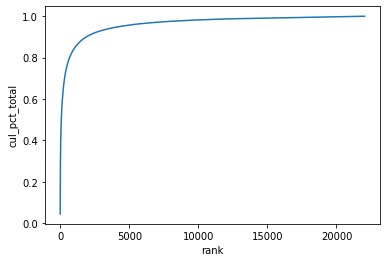

In [12]:
import seaborn as sns

# Cumulative Distribution Plot
sns.lineplot(x='rank', y='cul_pct_total', data=wc);

In [13]:
wc[wc['rank'] <= 20]['cul_pct_total'].max()

0.31101830776336686

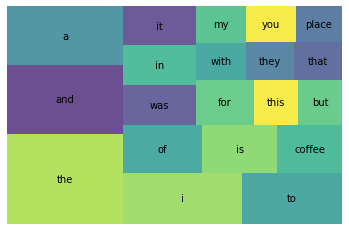

In [14]:
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [15]:
#spacy tokenizer
# Tokenizer
import spacy
from spacy.tokenizer import Tokenizer

nlp = spacy.load("en_core_web_lg")

tokenizer = Tokenizer(nlp.vocab)

In [16]:
# Tokenizer Pipe

tokens = []

""" Make them tokens """
for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    doc_tokens = [token.text for token in doc]
    tokens.append(doc_tokens)

shops['tokens'] = tokens
shops['tokens'].head(5)

0    [ , 11/25/2016, 1, check-in, Love, love, loved...
1    [ , 12/2/2016, Listed, in, Date, Night:, Austi...
2    [ , 11/30/2016, 1, check-in, Listed, in, Brunc...
3    [ , 11/25/2016, Very, cool, decor!, Good, drin...
4    [ , 12/3/2016, 1, check-in, They, are, located...
Name: tokens, dtype: object

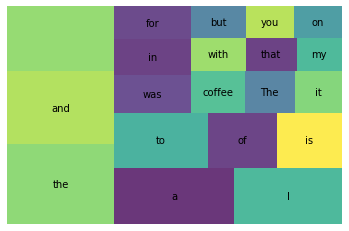

In [17]:
wc = count(shops['tokens'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [27]:
#stop words
STOP_WORDS = nlp.Defaults.stop_words.union([' ', 'coffee', 'get', 'check', 'got'])
    
tokens = []

for doc in tokenizer.pipe(shops['full_review_text'], batch_size=500):
    
    doc_tokens = []
    
    for token in doc: 
        if token.text.lower() not in STOP_WORDS:
            doc_tokens.append(token.text.lower())
   
    tokens.append(doc_tokens)
    
shops['tokens'] = tokens

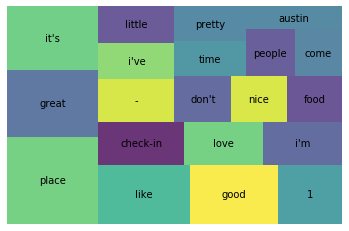

In [28]:
wc = count(shops['tokens'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

In [29]:
#lemmas with spacy
from spacy.lemmatizer import Lemmatizer

nlp = spacy.load("en_core_web_lg")

# Wrap it all in a function
def get_lemmas(text):

    lemmas = []
    
    doc = nlp(text)
    
    # Something goes here :P
    doc_tokens = []
    
    for token in doc: 
        if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_!= 'PRON'):
            lemmas.append(token.lemma_)
    
    return lemmas
shops['lemmas'] = shops['full_review_text'].apply(get_lemmas)
shops['lemmas'].head(5)

0    [ , 11/25/2016, 1, check, love, love, love, at...
1    [ , 12/2/2016, list, Date, Night, Austin, Ambi...
2    [ , 11/30/2016, 1, check, list, Brunch, Spots,...
3    [ , 11/25/2016, cool, decor, good, drink, nice...
4    [ , 12/3/2016, 1, check, locate, Northcross, m...
Name: lemmas, dtype: object

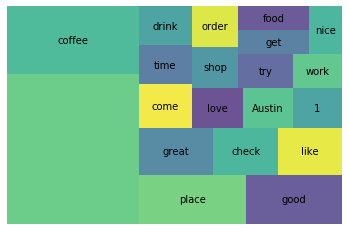

In [26]:
wc = count(shops['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()